In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("train.csv")
data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [3]:
data.count()

image_id             1821
healthy              1821
multiple_diseases    1821
rust                 1821
scab                 1821
dtype: int64

In [4]:
data.value_counts()

image_id    healthy  multiple_diseases  rust  scab
Train_0     0        0                  0     1       1
Train_436   0        1                  0     0       1
Train_46    1        0                  0     0       1
Train_459   0        0                  0     1       1
Train_458   0        0                  1     0       1
                                                     ..
Train_1540  0        0                  1     0       1
Train_154   0        0                  0     1       1
Train_1539  1        0                  0     0       1
Train_1538  1        0                  0     0       1
Train_999   0        0                  1     0       1
Name: count, Length: 1821, dtype: int64

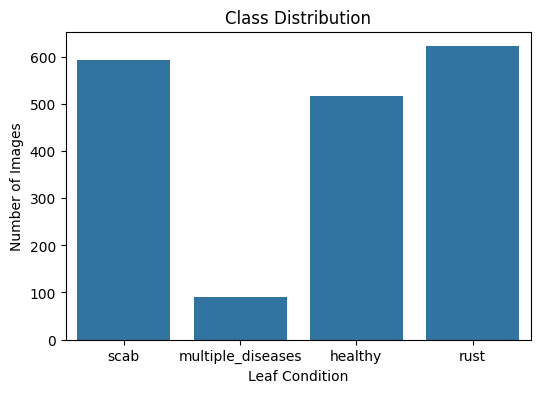

In [5]:
def get_label(row):
    for col in ['healthy', 'multiple_diseases', 'rust', 'scab']:
        if row[col] == 1:
            return col

data['label'] = data.apply(get_label, axis=1)

# Count plot
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Leaf Condition')
plt.ylabel('Number of Images')
plt.show()

In [6]:
data.head()

image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

In [7]:
data['label'][5]

'healthy'

In [8]:
data['label'].value_counts()

label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

In [9]:
import cv2
import os

In [10]:
image_id = data.iloc[5]['image_id']
image_path = os.path.join("images", image_id+".jpg")

In [11]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

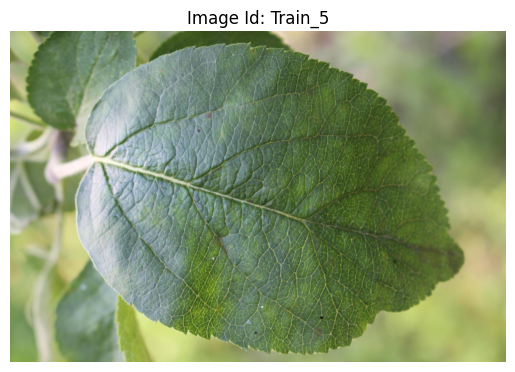

In [12]:
plt.imshow(img)
plt.title(f"Image Id: {image_id}")
plt.axis("off")
plt.show()


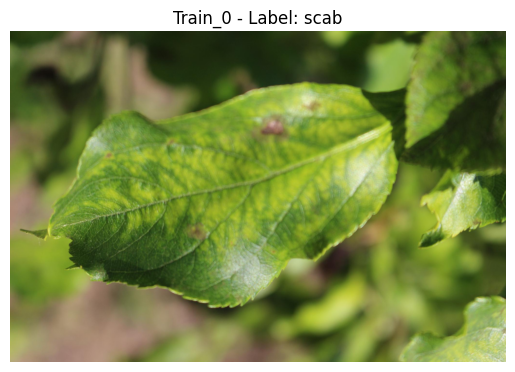

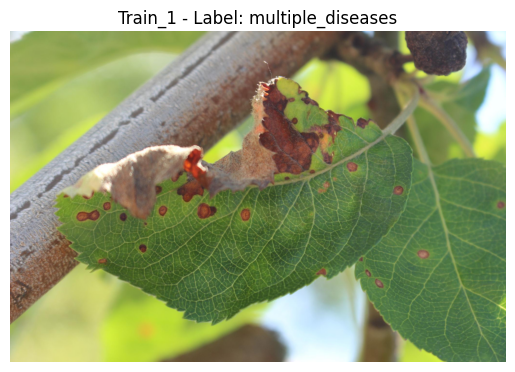

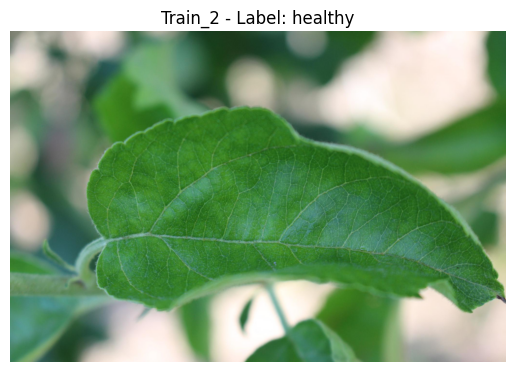

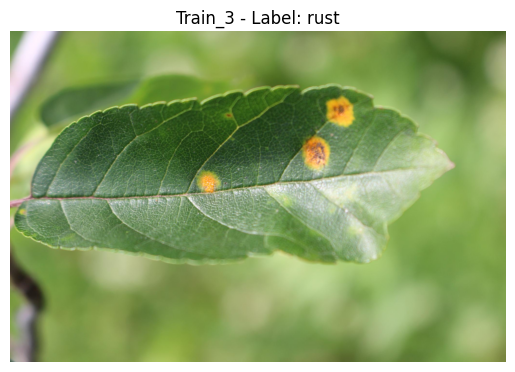

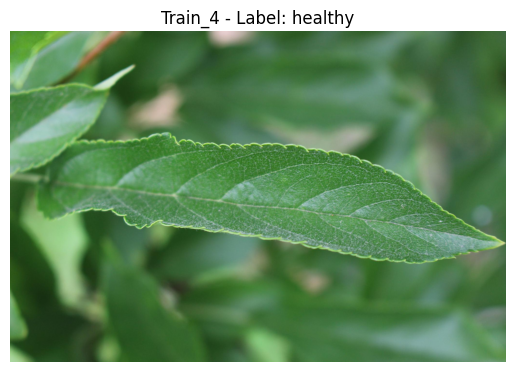

In [13]:
for i in range(5):  
    image_id = data.iloc[i]['image_id']
    label = data.iloc[i]['label']
    path = os.path.join("images", image_id + ".jpg")

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(img)
    plt.title(f"{image_id} - Label: {label}")
    plt.axis("off")
    plt.show()


In [14]:
data['label'].head()

0                 scab
1    multiple_diseases
2              healthy
3                 rust
4              healthy
Name: label, dtype: object

In [15]:
from skimage.feature import hog, local_binary_pattern
import mahotas
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [16]:
from skimage.feature import hog, local_binary_pattern
import mahotas
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [53]:
# Parameters for LBP
radius = 3
n_points = 8 * radius

def extract_features(img):
    features = []
    
    # Resize image to 128x128
    img = cv2.resize(img, (64, 64))
    
    # RGB Histograms
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # HOG
    hog_features = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    features.extend(hog_features)

    # LBP
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)
    features.extend(hist_lbp)

    # Haralick texture
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    features.extend(haralick)

    return np.array(features)


In [54]:
image_dir = "images/"
X = []
y = []

for i, row in tqdm(data.iterrows(), total=len(data)):
    image_id = row['image_id']
    label = row['label']
    path = os.path.join(image_dir, image_id + ".jpg")

    if not os.path.exists(path):
        continue

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    features = extract_features(img)
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


100%|██████████| 1821/1821 [01:30<00:00, 20.22it/s]

Feature matrix shape: (1821, 459)


In [55]:
data.head()

image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

In [56]:
X_scaled

array([[-0.05903567, -0.22051735, -0.32987061, ...,  0.27448761,
         0.04222022,  0.32232112],
       [-0.05903567, -0.22051735, -0.46282863, ...,  0.33524491,
        -0.09636075,  0.3971151 ],
       [-0.05903567, -0.22051735, -0.44444921, ..., -0.08656456,
        -0.4935732 ,  0.54459691],
       ...,
       [-0.05903567, -0.22051735, -0.46282863, ..., -0.68456357,
        -1.01116263,  0.71259039],
       [-0.05903567, -0.22051735, -0.46282863, ...,  0.24816993,
         0.24177587,  0.09464761],
       [-0.05903567, -0.22051735, -0.45449047, ..., -0.41347628,
        -0.43230784,  0.37805709]])

In [57]:
print("Shape:", X_scaled.shape)
print("First 5 rows:\n", X_scaled[:5])


Shape: (1821, 459)
First 5 rows:
 [[-0.05903567 -0.22051735 -0.32987061 ...  0.27448761  0.04222022
   0.32232112]
 [-0.05903567 -0.22051735 -0.46282863 ...  0.33524491 -0.09636075
   0.3971151 ]
 [-0.05903567 -0.22051735 -0.44444921 ... -0.08656456 -0.4935732
   0.54459691]
 [-0.05903567 -0.22051735 -0.46282863 ... -0.67874457 -0.23616717
   0.31287246]
 [-0.05903567 -0.22051735 -0.44714625 ... -0.58629931  1.06772421
  -0.93713476]]


In [58]:
data_features = pd.DataFrame(X_scaled)
print(data_features.head())

        0         1         2         3         4         5         6    \
0 -0.059036 -0.220517 -0.329871  0.981673  0.398866 -0.248984 -0.431300   
1 -0.059036 -0.220517 -0.462829 -0.756386 -1.060699 -1.432986 -1.701816   
2 -0.059036 -0.220517 -0.444449 -0.359232  0.080269  0.823245  1.682530   
3 -0.059036 -0.220517 -0.462829 -0.702197 -0.631805 -0.542083 -1.118977   
4 -0.059036 -0.220517 -0.447146 -0.250945 -0.350127 -0.177985  0.182502   

        7         8         9    ...       449       450       451       452  \
0 -0.830802 -1.087047 -1.178536  ... -0.134569 -0.773752 -0.225728 -0.099063   
1 -1.498576 -0.131342  1.148503  ...  0.037862 -0.513334  1.122613  0.038004   
2  1.956952  0.713996 -0.380372  ...  0.771284 -0.016082  0.975868  0.914288   
3 -1.639922 -2.024556 -1.584278  ... -0.781521  0.326630  1.490825 -0.761323   
4  1.625203  1.970369  1.357782  ... -1.222223  0.316278 -0.681883 -1.257690   

        453       454       455       456       457       458  
0  0

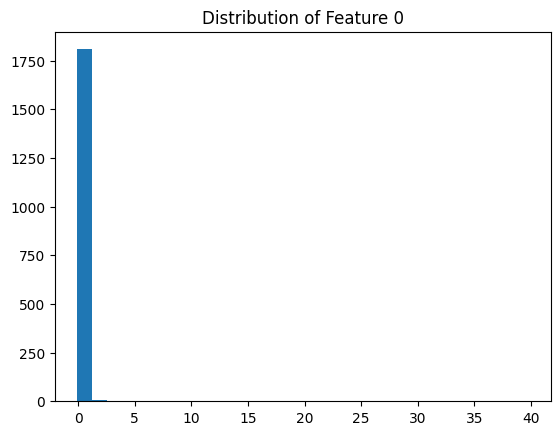

In [59]:
plt.hist(X_scaled[:, 0], bins=30)
plt.title("Distribution of Feature 0")
plt.show()


In [60]:
print("Feature matrix stats:")
print("Mean:", X_scaled.mean(axis=0))
print("Std Dev:", X_scaled.std(axis=0))
print("Min:", X_scaled.min(axis=0))
print("Max:", X_scaled.max(axis=0))


Feature matrix stats:
Mean: [ 1.59613612e-16 -3.19288192e-16 -7.65450306e-17 -6.99300280e-17
  6.96861569e-17  2.73135593e-17  8.70619703e-17  1.62174258e-17
  2.21434927e-16 -1.05127482e-16 -1.74672650e-16  2.64600106e-17
  1.34708280e-16  1.11144238e-16 -1.06571656e-16  9.02932619e-17
  1.13948755e-16 -3.66416276e-17  1.91438786e-17  8.89519711e-17
  4.80425999e-17  1.31812311e-16 -7.49903526e-18  8.30685816e-17
 -3.57271111e-17 -9.87677814e-18  1.70709746e-17  2.69477527e-17
 -1.02669718e-16  1.69185552e-16  8.82508417e-17  3.53308206e-17
  4.89205357e-16  3.47683929e-16  4.10404519e-16  3.49070946e-16
 -1.94212820e-16 -4.95058262e-17 -4.37500881e-17 -5.12129237e-17
  1.46322639e-17  4.07264679e-17 -6.46258323e-18  1.21081984e-16
 -1.34426304e-16 -1.29007794e-16  7.63926112e-17  2.39359451e-16
 -1.97169756e-16 -2.38383966e-16  8.68180992e-17  3.04838832e-17
  6.70645429e-17 -7.48684170e-17  5.85900234e-17  6.75522851e-17
 -1.06998430e-16  8.85556806e-17  8.70619703e-17  8.56673326e-

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have these from Step 1
# X_scaled -> standardized feature matrix
# y        -> string labels (e.g., 'rust', 'scab', ...)

# Step 1: Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [62]:
y_encoded

array([3, 1, 0, ..., 0, 2, 3], dtype=int64)

In [63]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


In [90]:
data['label'].value_counts()

label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

In [64]:
data[:10]

image_id  healthy  multiple_diseases  rust  scab              label
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy
5  Train_5        1                  0     0     0            healthy
6  Train_6        0                  1     0     0  multiple_diseases
7  Train_7        0                  0     0     1               scab
8  Train_8        0                  0     0     1               scab
9  Train_9        1                  0     0     0            healthy

In [65]:
y_encoded[:10]

array([3, 1, 0, 2, 0, 0, 1, 3, 3, 0], dtype=int64)

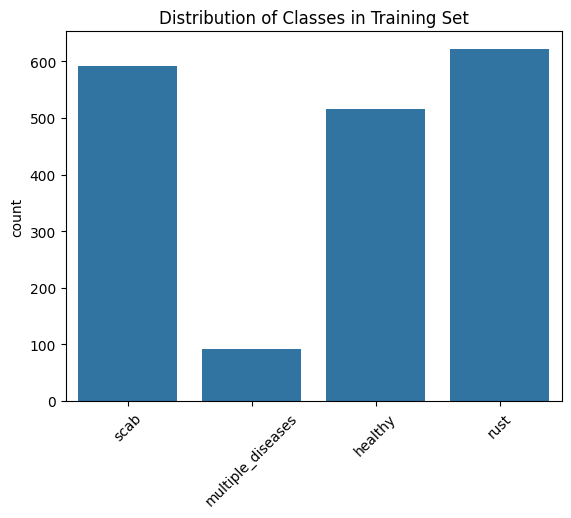

In [66]:
sns.countplot(x=y)
plt.title("Distribution of Classes in Training Set")
plt.xticks(rotation=45)
plt.show()

In [67]:
y_encoded.shape

(1821,)

Label Mapping: {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


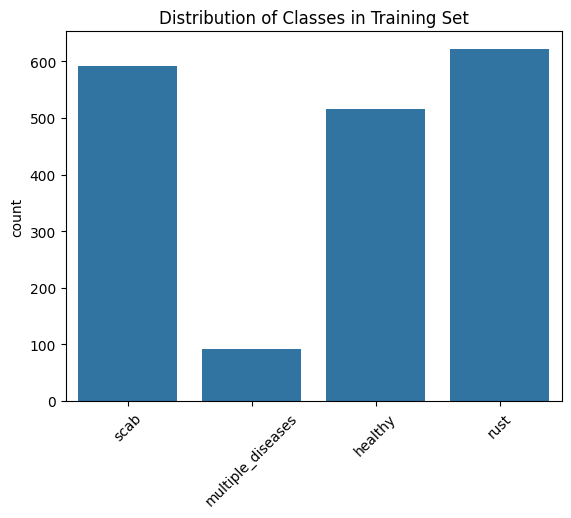

Train set shape: (1456, 459)
Validation set shape: (365, 459)


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have these from Step 1
# X_scaled -> standardized feature matrix
# y        -> string labels (e.g., 'rust', 'scab', ...)

# Step 1: Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# (Optional) View class mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Step 2: Visualize label distribution
sns.countplot(x=y)
plt.title("Distribution of Classes in Training Set")
plt.xticks(rotation=45)
plt.show()

# Step 3: Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


In [69]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [70]:
y_pred = rf_model.predict(X_val)


In [71]:
y_pred

array([2, 0, 2, 3, 2, 3, 0, 2, 0, 2, 0, 2, 2, 0, 3, 2, 2, 3, 0, 2, 3, 2,
       2, 0, 2, 0, 0, 2, 3, 0, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 0, 0, 2, 0,
       2, 0, 3, 0, 2, 0, 0, 3, 2, 3, 3, 0, 2, 3, 2, 0, 0, 3, 2, 3, 3, 0,
       3, 2, 2, 0, 3, 3, 0, 2, 0, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 0, 2, 0,
       3, 2, 3, 0, 0, 0, 3, 2, 0, 3, 2, 2, 3, 3, 0, 3, 0, 3, 2, 2, 2, 3,
       3, 3, 0, 0, 2, 0, 0, 0, 2, 2, 3, 2, 3, 0, 0, 3, 3, 2, 2, 3, 2, 0,
       0, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 0, 0, 2, 2, 2, 2, 0, 2,
       0, 3, 2, 2, 3, 0, 2, 2, 3, 2, 0, 2, 3, 2, 3, 2, 3, 0, 2, 3, 3, 0,
       3, 2, 0, 3, 2, 2, 3, 3, 2, 2, 3, 2, 0, 3, 2, 2, 3, 2, 0, 2, 3, 3,
       0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 3, 2, 2, 3, 3, 3, 3, 3, 0, 2, 3,
       0, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 3, 3, 0, 3, 2, 0, 3, 0, 3, 2, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 2, 2, 3, 0, 3, 3, 3, 3, 3, 0, 2,
       0, 2, 3, 3, 0, 3, 2, 0, 0, 2, 3, 3, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2,
       0, 1, 3, 3, 2, 2, 3, 0, 2, 0, 2, 0, 3, 3, 3,

In [72]:
y_pred.shape

(365,)

In [73]:
y_val.shape

(365,)

In [74]:
y_val

array([2, 0, 2, 2, 2, 3, 0, 3, 0, 2, 0, 3, 1, 2, 2, 3, 0, 2, 0, 2, 3, 2,
       2, 2, 2, 0, 3, 0, 0, 2, 0, 2, 2, 2, 3, 0, 3, 3, 2, 3, 0, 3, 3, 2,
       3, 2, 3, 0, 2, 0, 0, 2, 0, 1, 0, 3, 2, 0, 3, 0, 0, 2, 2, 3, 3, 0,
       3, 2, 2, 3, 3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 3, 0, 2, 2, 3, 2, 3, 3,
       3, 2, 0, 0, 0, 0, 3, 3, 2, 0, 1, 2, 3, 3, 0, 1, 2, 2, 2, 3, 1, 1,
       2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 3, 3, 0, 0, 0, 2, 3, 2, 2, 3, 2, 0,
       0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 0, 3, 0, 0, 0, 3, 2, 2, 0, 2,
       0, 3, 2, 3, 2, 0, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 0, 1, 3, 3, 0,
       3, 3, 0, 3, 2, 2, 3, 3, 2, 3, 3, 3, 0, 3, 2, 2, 3, 2, 0, 2, 3, 3,
       0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 0, 0, 1, 3, 3, 2, 1, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 0, 0, 3, 0, 3, 2, 3,
       2, 0, 2, 0, 0, 0, 0, 2, 3, 0, 3, 2, 3, 2, 1, 3, 3, 3, 1, 3, 0, 2,
       0, 3, 3, 3, 0, 2, 2, 0, 0, 2, 1, 3, 0, 0, 2, 3, 3, 2, 0, 0, 2, 2,
       0, 3, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 0, 3, 0,

Validation Accuracy: 0.5917808219178082

Classification Report:
                   precision    recall  f1-score   support

          healthy       0.65      0.62      0.63       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.58      0.66      0.61       125
             scab       0.57      0.59      0.58       119

         accuracy                           0.59       365
        macro avg       0.45      0.47      0.46       365
     weighted avg       0.57      0.59      0.58       365



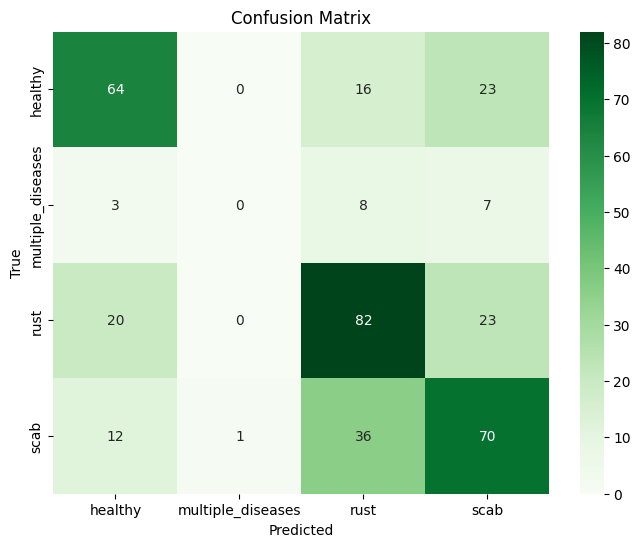

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


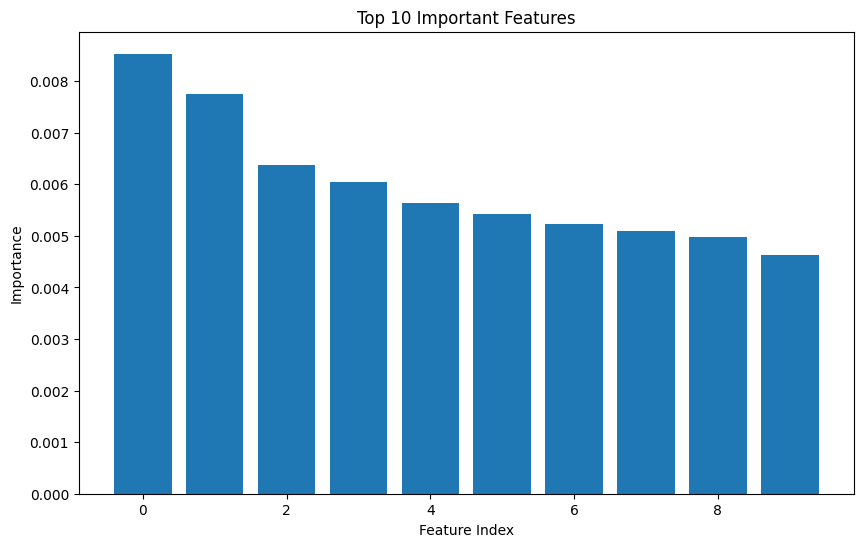

In [76]:
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features")
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


In [77]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define distributions for random search
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Base model
rf = RandomForestClassifier(random_state=42)

# Random Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                # Number of random combinations to try
    cv=3,                     # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

# Fit
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000176F22CAB10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000176864A19A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000176F115CDA0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [78]:
# Best model
best_rf_random = random_search.best_estimator_

# Predict & evaluate
y_random_pred = best_rf_random.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Random Search Accuracy:", accuracy_score(y_val, y_random_pred))
print("\nRandom Search Classification Report:")
print(classification_report(y_val, y_random_pred, target_names=label_encoder.classes_))


Random Search Accuracy: 0.589041095890411

Random Search Classification Report:
                   precision    recall  f1-score   support

          healthy       0.66      0.59      0.63       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.57      0.62      0.59       125
             scab       0.56      0.64      0.60       119

         accuracy                           0.59       365
        macro avg       0.45      0.46      0.45       365
     weighted avg       0.56      0.59      0.57       365



c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

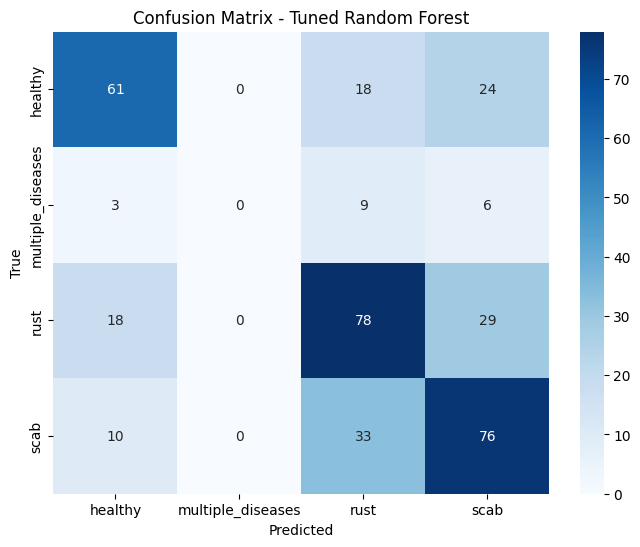

In [79]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_random_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()


In [103]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Now train Random Forest or SVM on this balanced data
rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

y_pred_rf_sm = rf_sm.predict(X_val)

from sklearn.metrics import classification_report, accuracy_score
print("RF after SMOTE Accuracy:", accuracy_score(y_val, y_pred_rf_sm))
print(classification_report(y_val, y_pred_rf_sm, target_names=label_encoder.classes_))


RF after SMOTE Accuracy: 0.5506849315068493
                   precision    recall  f1-score   support

          healthy       0.61      0.63      0.62       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.52      0.53      0.52       125
             scab       0.57      0.59      0.58       119

         accuracy                           0.55       365
        macro avg       0.42      0.44      0.43       365
     weighted avg       0.53      0.55      0.54       365



In [128]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)

print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm, target_names=label_encoder.classes_))


SVM Accuracy: 0.6082191780821918
                   precision    recall  f1-score   support

          healthy       0.63      0.55      0.59       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.58      0.63      0.60       125
             scab       0.63      0.72      0.67       119

         accuracy                           0.61       365
        macro avg       0.46      0.48      0.47       365
     weighted avg       0.58      0.61      0.59       365



c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

SVM Accuracy: 0.6082191780821918

Classification Report (SVM):
                   precision    recall  f1-score   support

          healthy       0.63      0.55      0.59       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.58      0.63      0.60       125
             scab       0.63      0.72      0.67       119

         accuracy                           0.61       365
        macro avg       0.46      0.48      0.47       365
     weighted avg       0.58      0.61      0.59       365



c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

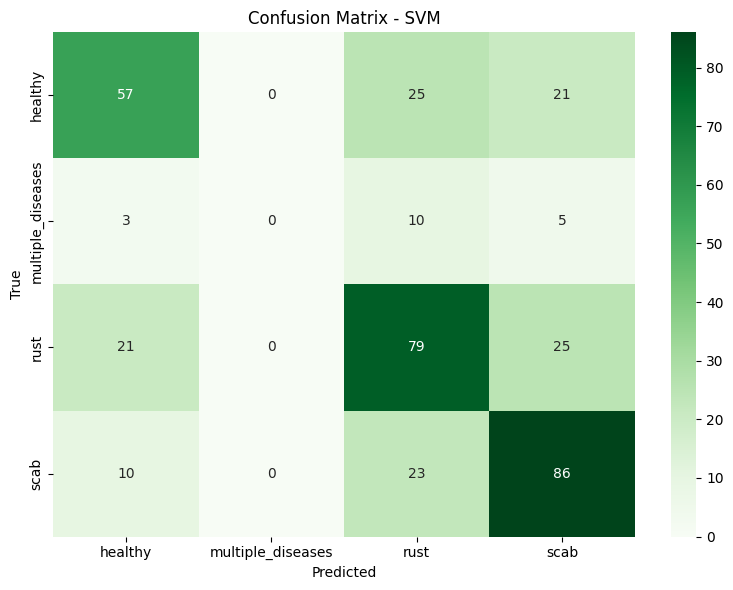

In [88]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Print accuracy
print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))

# Print classification report
print("\nClassification Report (SVM):")
print(classification_report(y_val, y_pred_svm, target_names=label_encoder.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_svm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()


In [124]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

svm_bal = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svm_bal.fit(X_train, y_train)
y_pred_bal = svm_bal.predict(X_val)

print("Balanced SVM Accuracy:", accuracy_score(y_val, y_pred_bal))
print(classification_report(y_val, y_pred_bal, target_names=label_encoder.classes_))


Balanced SVM Accuracy: 0.5835616438356165
                   precision    recall  f1-score   support

          healthy       0.59      0.60      0.60       103
multiple_diseases       0.20      0.06      0.09        18
             rust       0.56      0.56      0.56       125
             scab       0.61      0.67      0.64       119

         accuracy                           0.58       365
        macro avg       0.49      0.47      0.47       365
     weighted avg       0.57      0.58      0.57       365



In [122]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

svm_smote = SVC(kernel='rbf', C=5, gamma='scale')
svm_smote.fit(X_train_bal, y_train_bal)
y_pred_svm_smote = svm_smote.predict(X_val)

print("SMOTE-SVM Accuracy:", accuracy_score(y_val, y_pred_svm_smote))
print(classification_report(y_val, y_pred_svm_smote, target_names=label_encoder.classes_))


SMOTE-SVM Accuracy: 0.5726027397260274
                   precision    recall  f1-score   support

          healthy       0.56      0.59      0.58       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.57      0.56      0.56       125
             scab       0.60      0.66      0.63       119

         accuracy                           0.57       365
        macro avg       0.43      0.45      0.44       365
     weighted avg       0.55      0.57      0.56       365



In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_val)

print("KNN Accuracy:", accuracy_score(y_val, y_pred_knn))
print(classification_report(y_val, y_pred_knn, target_names=label_encoder.classes_))


KNN Accuracy: 0.473972602739726
                   precision    recall  f1-score   support

          healthy       0.52      0.50      0.51       103
multiple_diseases       0.08      0.06      0.06        18
             rust       0.44      0.47      0.46       125
             scab       0.52      0.51      0.51       119

         accuracy                           0.47       365
        macro avg       0.39      0.39      0.39       365
     weighted avg       0.47      0.47      0.47       365



In [144]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr, target_names=label_encoder.classes_))


Logistic Regression Accuracy: 0.4986301369863014
                   precision    recall  f1-score   support

          healthy       0.50      0.50      0.50       103
multiple_diseases       0.12      0.22      0.16        18
             rust       0.53      0.50      0.51       125
             scab       0.58      0.55      0.56       119

         accuracy                           0.50       365
        macro avg       0.43      0.44      0.43       365
     weighted avg       0.52      0.50      0.51       365



In [145]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('svm', svm),
    ('knn', knn),
    ('logistic', lr)    
], voting='hard')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)

print("Ensemble Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report (Voting Ensemble):")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))



Ensemble Accuracy: 0.6054794520547945

Classification Report (Voting Ensemble):
                   precision    recall  f1-score   support

          healthy       0.59      0.66      0.62       103
multiple_diseases       0.25      0.06      0.09        18
             rust       0.58      0.60      0.59       125
             scab       0.66      0.65      0.66       119

         accuracy                           0.61       365
        macro avg       0.52      0.49      0.49       365
     weighted avg       0.59      0.61      0.60       365



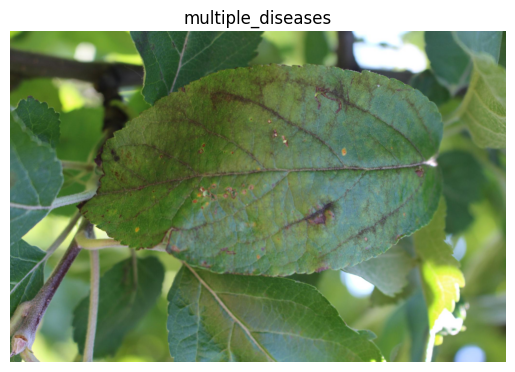

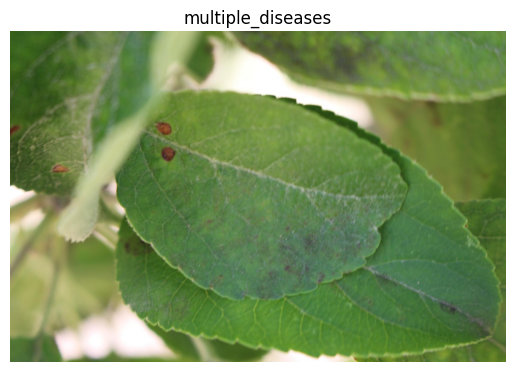

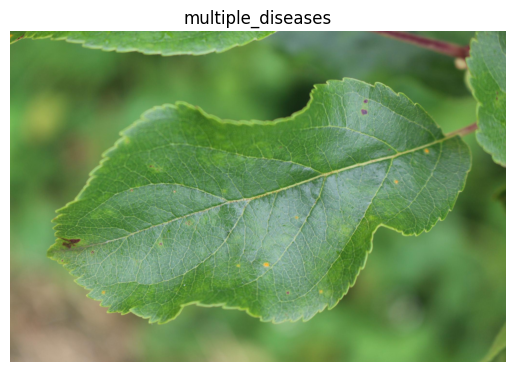

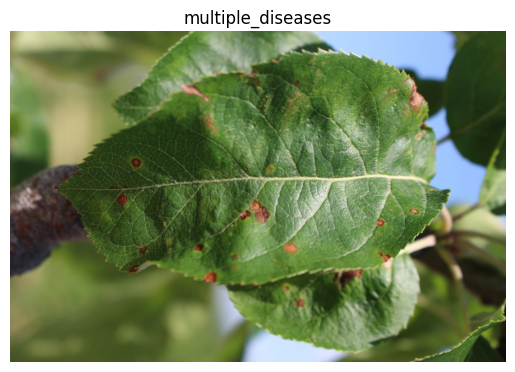

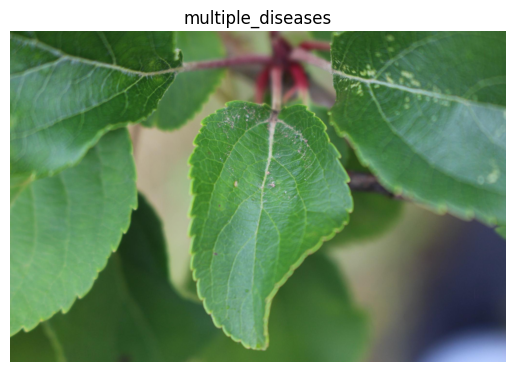

In [98]:
samples = data[data['label'] == 'multiple_diseases'].sample(5)

for i, row in samples.iterrows():
    path = os.path.join(image_dir, row['image_id'] + ".jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("multiple_diseases")
    plt.axis('off')
    plt.show()


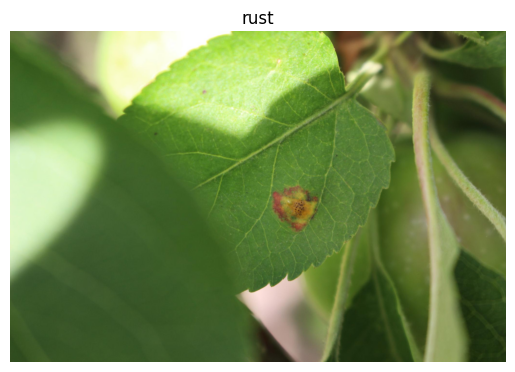

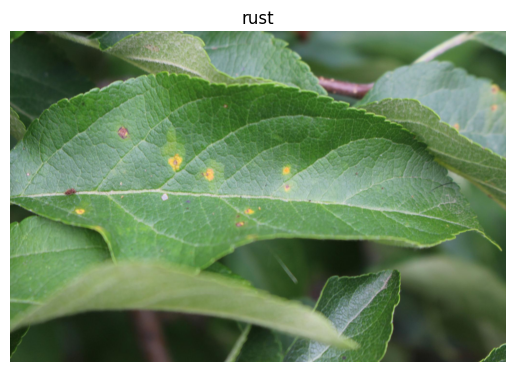

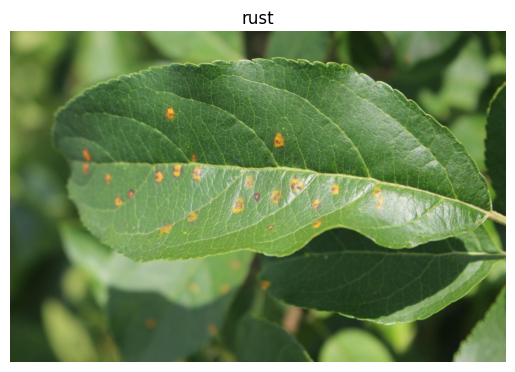

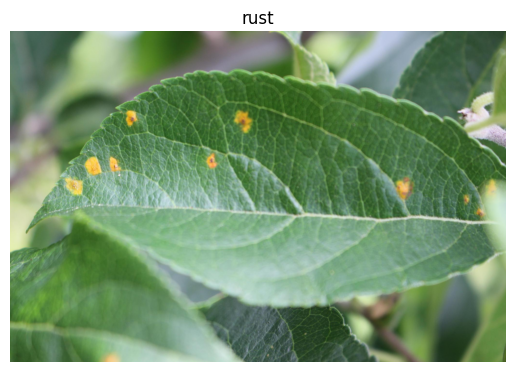

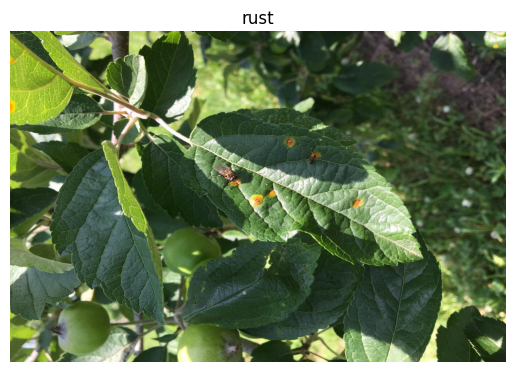

In [99]:
samples = data[data['label'] == 'rust'].sample(5)

for i, row in samples.iterrows():
    path = os.path.join(image_dir, row['image_id'] + ".jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("rust")
    plt.axis('off')
    plt.show()


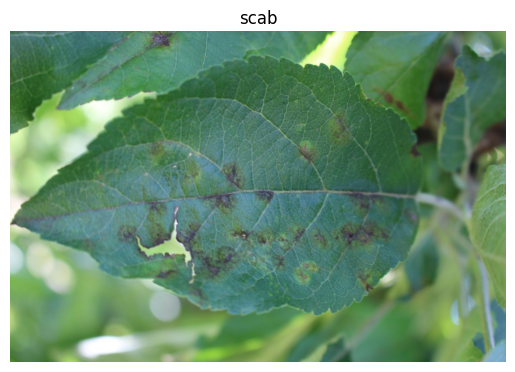

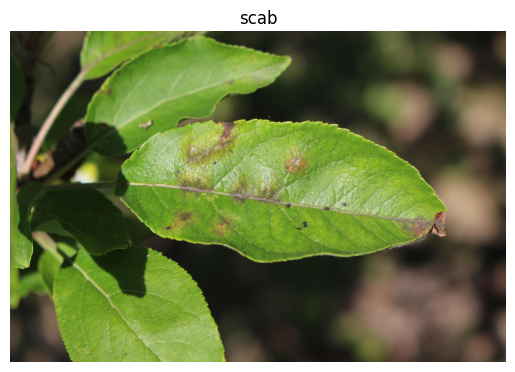

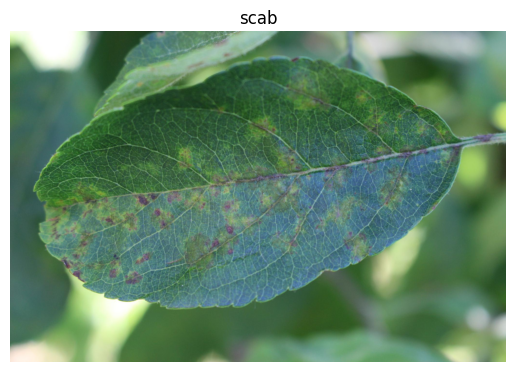

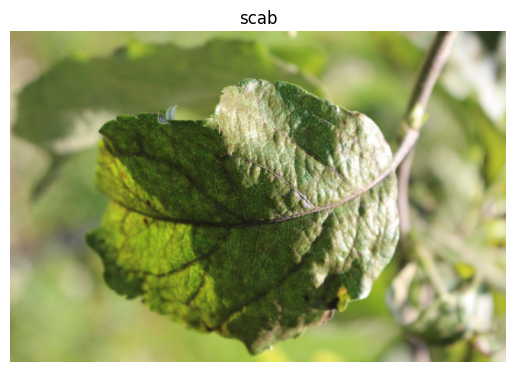

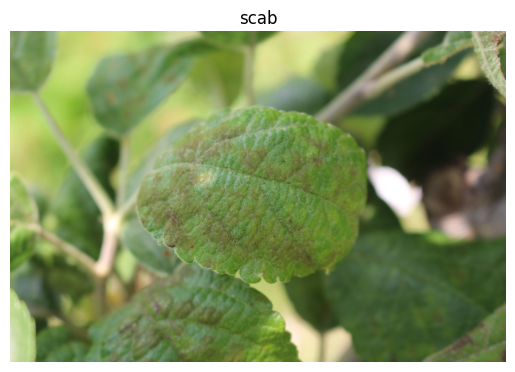

In [101]:
samples = data[data['label'] == 'scab'].sample(5)

for i, row in samples.iterrows():
    path = os.path.join(image_dir, row['image_id'] + ".jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("scab")
    plt.axis('off')
    plt.show()


In [146]:
import cv2
import numpy as np

# Step 1: Load and preprocess image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))  # Ensure same size used in training
    
    # Step 2: Extract features
    features = extract_features(img)  # This should return 1D feature vector
    features = np.array(features).reshape(1, -1)
    
    # Step 3: Scale features
    features_scaled = scaler.transform(features)
    
    # Step 4: Predict
    pred_encoded = ensemble.predict(features_scaled)[0]
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    
    return pred_label


In [151]:
image_path = "test images/Test_15.jpg"  # Replace with your own image
prediction = predict_image(image_path)
print("Predicted class:", prediction)


Predicted class: healthy


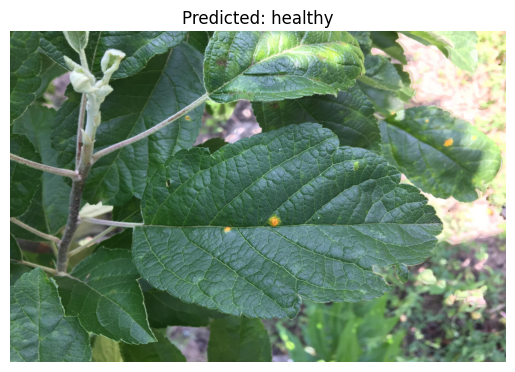

In [152]:
import matplotlib.pyplot as plt

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()


In [153]:
import os

folder = "test images/"
for filename in os.listdir(folder):
    if filename.endswith(".jpg"):
        path = os.path.join(folder, filename)
        pred = predict_image(path)
        print(f"{filename}: {pred}")


Test_0.jpg: rust
Test_1.jpg: rust
Test_10.jpg: rust
Test_100.jpg: rust
Test_1000.jpg: scab
Test_1001.jpg: scab
Test_1002.jpg: rust
Test_1003.jpg: rust
Test_1004.jpg: rust
Test_1005.jpg: rust
Test_1006.jpg: scab
Test_1007.jpg: scab
Test_1008.jpg: healthy
Test_1009.jpg: healthy
Test_101.jpg: healthy
Test_1010.jpg: healthy
Test_1011.jpg: rust
Test_1012.jpg: rust
Test_1013.jpg: scab
Test_1014.jpg: scab
Test_1015.jpg: scab
Test_1016.jpg: scab
Test_1017.jpg: rust
Test_1018.jpg: scab
Test_1019.jpg: healthy
Test_102.jpg: rust
Test_1020.jpg: healthy
Test_1021.jpg: healthy
Test_1022.jpg: rust
Test_1023.jpg: healthy
Test_1024.jpg: scab
Test_1025.jpg: healthy
Test_1026.jpg: rust
Test_1027.jpg: scab
Test_1028.jpg: healthy
Test_1029.jpg: healthy
Test_103.jpg: rust
Test_1030.jpg: rust
Test_1031.jpg: scab
Test_1032.jpg: healthy
Test_1033.jpg: healthy
Test_1034.jpg: healthy
Test_1035.jpg: healthy
Test_1036.jpg: rust
Test_1037.jpg: rust
Test_1038.jpg: scab
Test_1039.jpg: scab
Test_104.jpg: healthy
Test_

In [169]:
import os
import re
import pandas as pd

submission = []

folder = "test images/"

# Sort filenames based on numeric order (e.g., Test_1, Test_2, ..., Test_100)
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# Apply numeric sort
sorted_files = sorted(os.listdir(folder), key=extract_number)

for filename in sorted_files:
    if filename.endswith(".jpg"):
        image_id = filename.replace(".jpg", "")
        path = os.path.join(folder, filename)

        pred = predict_image(path)
        submission.append([image_id, pred])


In [ ]:
submission_df = pd.DataFrame(submission, columns=["image_id", "label"])
submission_df.to_csv("submission_final.csv", index=False)
print("✅ submission_final.csv saved with natural sort order.")


✅ submission.csv saved with natural sort order.


In [179]:
submission_df[40:50]

image_id    label
40  Test_40     rust
41  Test_41  healthy
42  Test_42     scab
43  Test_43  healthy
44  Test_44     scab
45  Test_45     scab
46  Test_46  healthy
47  Test_47     scab
48  Test_48     scab
49  Test_49  healthy

In [180]:
data[40:50]

image_id  healthy  multiple_diseases  rust  scab    label
40  Train_40        0                  0     0     1     scab
41  Train_41        0                  0     0     1     scab
42  Train_42        0                  0     0     1     scab
43  Train_43        1                  0     0     0  healthy
44  Train_44        0                  0     0     1     scab
45  Train_45        0                  0     1     0     rust
46  Train_46        1                  0     0     0  healthy
47  Train_47        0                  0     1     0     rust
48  Train_48        0                  0     0     1     scab
49  Train_49        0                  0     0     1     scab

In [166]:
data['label'][1000]

'rust'

In [181]:
data['label'].value_counts()

label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

In [182]:
submission_df['label'].value_counts()

label
healthy              685
rust                 614
scab                 509
multiple_diseases     13
Name: count, dtype: int64